Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', )
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'], color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'], color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
type(data_dir_train.absolute())

pathlib.PosixPath

In [10]:
for class_name in class_names:
  fileName = os.listdir("/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + class_name)[0]
  print(fileName)

ISIC_0025780.jpg
ISIC_0024595.jpg
ISIC_0027141.jpg
ISIC_0000141.jpg
ISIC_0000028.jpg
ISIC_0024890.jpg
ISIC_0010863.jpg
ISIC_0025811.jpg
ISIC_0025606.jpg


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

actinic keratosis


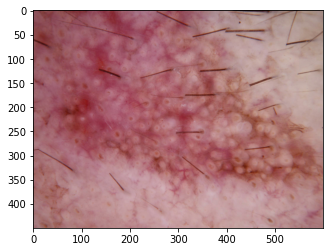

basal cell carcinoma


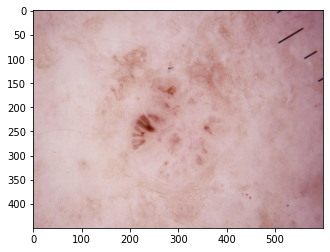

dermatofibroma


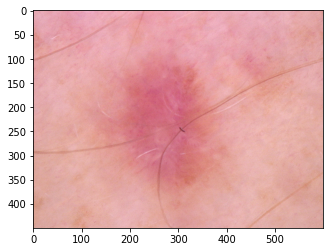

melanoma


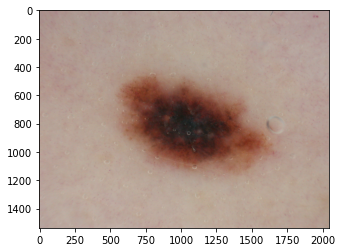

nevus


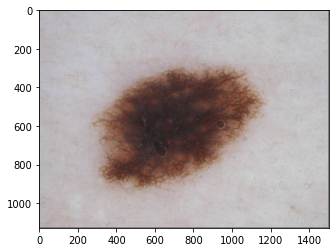

pigmented benign keratosis


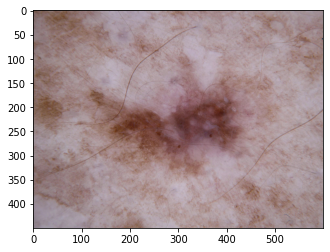

seborrheic keratosis


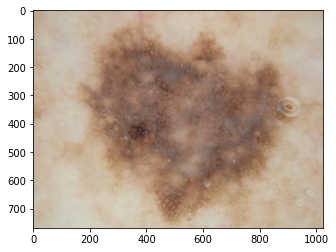

squamous cell carcinoma


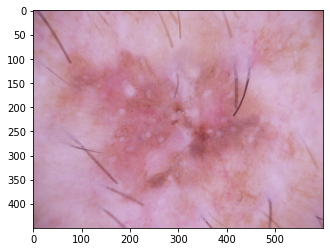

vascular lesion


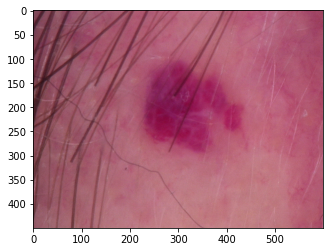

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for class_name in class_names:
  fileName = os.listdir("/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + class_name)[0]
  print(class_name)
  img = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + class_name + "/" + fileName)
  plt.imshow(img)
  plt.show()
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
print(train_ds)
val_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None, 9)), types: (tf.float32, tf.float32)>


<PrefetchDataset shapes: ((None, 180, 180, 3), (None, 9)), types: (tf.float32, tf.float32)>

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
### Your code goes here

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [16]:
normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds_val))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [17]:
num_classes = 9

#model = tf.keras.Sequential([
# tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Conv2D(32, 3, activation='relu'),
#  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Flatten(),
#  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dense(num_classes)
#])



In [18]:
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180, 180, 3))) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(normalized_ds)
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 118336)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#model.fit(train_ds, batch_size=batch_size, epochs=20, validation_data=val_ds)
#model.build(input_shape=(180,180,3))

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 118336)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

### Train the model

In [21]:
epochs = 20
history = model.fit(
  normalized_ds,
  validation_data=normalized_ds_val,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 1172s 831ms/step - loss: 1.8206 - accuracy: 0.3115 - val_loss: 1.5535 - val_accuracy: 0.4112
Epoch 2/20
281/281 [==============================] - 20s 72ms/step - loss: 1.4391 - accuracy: 0.4543 - val_loss: 1.2583 - val_accuracy: 0.5434
Epoch 3/20
281/281 [==============================] - 20s 73ms/step - loss: 1.2330 - accuracy: 0.5359 - val_loss: 1.1278 - val_accuracy: 0.6075
Epoch 4/20
281/281 [==============================] - 21s 73ms/step - loss: 1.0630 - accuracy: 0.6090 - val_loss: 0.8988 - val_accuracy: 0.7000
Epoch 5/20
281/281 [==============================] - 21s 73ms/step - loss: 0.8656 - accuracy: 0.6828 - val_loss: 0.9095 - val_accuracy: 0.6956
Epoch 6/20
281/281 [==============================] - 21s 73ms/step - loss: 0.7470 - accuracy: 0.7295 - val_loss: 0.8064 - val_accuracy: 0.7241
Epoch 7/20
281/281 [==============================] - 21s 74ms/step - loss: 0.6379 - accuracy: 0.7728 - val_loss: 0.6046 - val_accura

### Visualizing training results

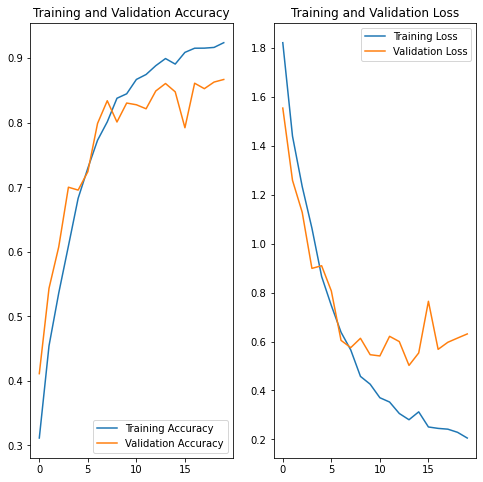

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here


Based on the training accuracy around 70 to 72% and validation accuracy of just 50 to 55%, we can say that the model has overfitted on the training dataset. Interestingly, the accuracy values change every time we rerun the model but the pattern of having a huge gap between train and val remains same.

Thus changing the dropout to see if it helps

In [ ]:
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180, 180, 3))) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(normalized_ds)
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.2))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 118336)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [23]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
epochs = 20
history = model.fit(
  normalized_ds,
  validation_data=normalized_ds_val,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 20s 70ms/step - loss: 33.8185 - accuracy: 0.1373 - val_loss: 2.2145 - val_accuracy: 0.1331
Epoch 2/20
281/281 [==============================] - 20s 70ms/step - loss: 2.2095 - accuracy: 0.1293 - val_loss: 2.2042 - val_accuracy: 0.1331
Epoch 3/20
281/281 [==============================] - 20s 70ms/step - loss: 2.2014 - accuracy: 0.1293 - val_loss: 2.1982 - val_accuracy: 0.1331
Epoch 4/20
281/281 [==============================] - 20s 70ms/step - loss: 2.1967 - accuracy: 0.1293 - val_loss: 2.1948 - val_accuracy: 0.1331
Epoch 5/20
281/281 [==============================] - 20s 70ms/step - loss: 2.1940 - accuracy: 0.1293 - val_loss: 2.1928 - val_accuracy: 0.1331
Epoch 6/20
281/281 [==============================] - 20s 70ms/step - loss: 2.1925 - accuracy: 0.1293 - val_loss: 2.1917 - val_accuracy: 0.1331
Epoch 7/20
281/281 [==============================] - 20s 70ms/step - loss: 2.1917 - accuracy: 0.1293 - val_loss: 2.1910 - val_accuracy

With increased dropout from 0.1 to 0.2 in the first layer, the model seems to have overfitted even more as the accuracy and loss difference between training and validation set is even more stark now. Thus, we will try some data augmentation strategies to see if we can generalize the model well

In [39]:
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180, 180, 3))) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(normalized_ds)
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.2))

# softmax layer
model.add(Dense(num_classes, activation='relu'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20

# model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 118336)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Your code goes here
history = model.fit(
  normalized_ds,
  validation_data=normalized_ds_val,
  epochs=50
)

Epoch 1/50
281/281 [==============================] - 21s 74ms/step - loss: 3.3870 - accuracy: 0.1420 - val_loss: 2.1740 - val_accuracy: 0.1282
Epoch 2/50
281/281 [==============================] - 21s 73ms/step - loss: 2.2173 - accuracy: 0.1409 - val_loss: 2.1090 - val_accuracy: 0.1807
Epoch 3/50
281/281 [==============================] - 21s 74ms/step - loss: 2.2101 - accuracy: 0.1378 - val_loss: 2.1744 - val_accuracy: 0.1816
Epoch 4/50
281/281 [==============================] - 21s 74ms/step - loss: 2.1926 - accuracy: 0.1430 - val_loss: 2.1862 - val_accuracy: 0.1331
Epoch 5/50
281/281 [==============================] - 21s 73ms/step - loss: 2.1846 - accuracy: 0.1420 - val_loss: 2.1281 - val_accuracy: 0.1847
Epoch 6/50
281/281 [==============================] - 21s 74ms/step - loss: 2.1356 - accuracy: 0.1852 - val_loss: 2.1737 - val_accuracy: 0.1491
Epoch 7/50
281/281 [==============================] - 20s 73ms/step - loss: 2.1459 - accuracy: 0.1760 - val_loss: 2.1093 - val_accuracy:

There are two ways we can achieve data augmentation in tensorflow:
1. Here we are using a strategy to introduce keras preprocessing layer which will add certain augmentation techniques to each image while training

### Todo:
### Create the model, compile and train the model


In [ ]:
data_augmentation = Sequential()

In [ ]:
data_augmentation.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))

In [ ]:
data_augmentation.add(layers.experimental.preprocessing.RandomRotation(0.2))

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer

data_augmentation.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180, 180, 3))) # input shape = (img_rows, img_cols, 1)
data_augmentation.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(normalized_ds)
# second conv layer
data_augmentation.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
data_augmentation.add(MaxPooling2D(pool_size=(2, 2)))
data_augmentation.add(Dropout(0.2))

# flatten and put a fully connected layer
data_augmentation.add(Flatten())
data_augmentation.add(Dense(128, activation='relu')) # fully connected
data_augmentation.add(Dropout(0.5))

# softmax layer
data_augmentation.add(Dense(num_classes, activation='softmax'))


In [ ]:
data_augmentation.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = data_augmentation.fit(
  normalized_ds,
  validation_data=normalized_ds_val,
  epochs=epochs
)

### Compiling the model

In [ ]:
## Your code goes here

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After applying the data augmentation technique, the difference of accuracy and loss between train and validation is reduced drastically. Thus, we can say that the model is now more generalized as compared to before.

2. The second approach is to apply data augmentation on the dataset and then feed the dataset to our exising model

In [ ]:
def augment_using_ops(images, labels):
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	return (images, labels)

In [ ]:
#ds = tf.data.Dataset.from_tensor_slices(imagePaths)
ds = (train_ds
	.map(augment_using_ops, num_parallel_calls=AUTOTUNE)
)

In [ ]:
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180, 180, 3))) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(normalized_ds)
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = data_augmentation.fit(
  ds,
  validation_data=normalized_ds_val,
  epochs=epochs
)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

As we can see that the augmentation techniques are helping the model to run and generalize in a better way. Currently the training and validation accuracies are pretty close to each other. However, the overall accuracy is very low at around 20%  and the loss is also high, around 2. We will see how we can use class imbalance techniques to resolve this.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
for class_name in class_names:
  list = os.listdir("/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + class_name) # dir is your directory path
  number_files = len(list)
  print(class_name + ":" + str(number_files))

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Answer: seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis (463) and basal cell carcinoma(377)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

In [ ]:
import glob2

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob2.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob2.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = train_ds.append(df2)

In [ ]:
df2['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/Colab Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'], color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'], color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

In [ ]:
### Your code goes here

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))### Your code goes here

normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds_val))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180, 180, 3))) # input shape = (img_rows, img_cols, 1)
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(normalized_ds)
# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
history = model.fit(
  normalized_ds,
  validation_data=normalized_ds_val,
  epochs=epochs
)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The overall accuracy of the model is improved increadebly after class rebalancing. The train and validation accuracy is above 85%. There is still some gap between training and validation accuracy so the model seems to overfitting a bit on the training data.